In [1]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
save_dir1 = "../figures/magnetic_data_EDA/raw_plots"
# save_dir2 = "../figures/magnetic_data_EDA/transformed_plots"
os.makedirs(save_dir1, exist_ok=True)
# os.makedirs(save_dir2, exist_ok=True)

# 2020 Data Analysis

In [3]:
ddf = dd.read_parquet("../data/preprocessed/solar_flare_2020/train/", engine = "pyarrow")
print("--- Loaded the dataset ---")
ddf = ddf.set_index("record_id")
print("Defined Divisions", ddf.divisions)

--- Loaded the dataset ---
Defined Divisions (np.int64(1), np.int64(2931), np.int64(6838), np.int64(10745), np.int64(14652), np.int64(18559), np.int64(22466), np.int64(26373), np.int64(30605), np.int64(34326), np.int64(38047), np.int64(41879), np.int64(45489), np.int64(49954), np.int64(53867), np.int64(57396), np.int64(61695), np.int64(65425), np.int64(69152), np.int64(73225), np.int64(76609), np.int64(80709), np.int64(84816), np.int64(89065), np.int64(92632), np.int64(94867), np.int64(97097), np.int64(98932), np.int64(100999), np.int64(102886), np.int64(104524), np.int64(106848), np.int64(108996), np.int64(111125), np.int64(112703), np.int64(114876), np.int64(116443), np.int64(118670), np.int64(120540), np.int64(122537), np.int64(124619), np.int64(126304), np.int64(128468), np.int64(129909), np.int64(132070), np.int64(134232), np.int64(136342), np.int64(139513), np.int64(143231), np.int64(147446), np.int64(151407), np.int64(154716), np.int64(158875), np.int64(162888), np.int64(166521)

In [4]:
print(ddf.info())
print("\n------------------------------------------\n")
print(ddf.describe().compute())

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 34 entries, TOTUSJH to label
dtypes: float64(33), string(1)None

------------------------------------------

            TOTUSJH        TOTBSQ        TOTPOT       TOTUSJZ       ABSNJZH  \
count  1.278372e+07  1.278372e+07  1.278372e+07  1.278372e+07  1.278372e+07   
mean   4.713117e+02  6.339369e+09  1.037117e+23  9.686802e+12  5.338029e+01   
std    8.393582e+02  1.253316e+10  1.136953e+24  1.633028e+13  1.450509e+02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    4.321222e+01  3.285640e+08  2.345178e+21  9.657009e+11  3.129039e+00   
50%    1.542327e+02  1.415764e+09  1.034712e+22  3.316949e+12  1.048224e+01   
75%    6.248079e+02  8.102095e+09  1.000415e+23  1.320731e+13  4.670088e+01   
max    1.152325e+04  1.431918e+11  8.684370e+26  2.238240e+14  2.980218e+03   

            SAVNCPP        USFLUX         TOTFZ       MEANPOT          EPSZ  \
count  1.278372e+07  1.278372e+07  1.278372e+0

## Scale
Looking at the mean and std (standard deviation) values across different columns such as
- TOTPOT has a mean in the order of 10^23.
- SAVNCPP has a mean in the order of 10^12.
- EPSZ has a mean of approximately -0.5.
- FDIM has a mean close to zero.

This vast difference in scales is a strong indicator that we need to perform feature scaling (like Standardization or Normalization) before implementing most machine learning models (especially distance-based algorithms like SVM or algorithms that use gradient descent like neural networks).

## Skewedness
Note that for many features, the mean is significantly different from the median (the 50% mark). As we can see for TOTUSJH, the mean is ~471, while the 50th percentile (median) is ~155. The mean is pulled higher than the median, which suggests a right-skewed distribution and this is further confirmed by the 75th percentile being ~727, while the maximum value is a much larger 11,523.

For features with such high skewness, we might need to apply transformations to make their distributions more symmetrical such as
- Logarithmic transformation: `np.log1p(x)` (useful for right-skewed data and handles zero values).
- Square root transformation: `np.sqrt(x)`.
- Box-Cox transformation.

## Zero Inflation
For features like FDIM, BZ_FDIM, BT_FDIM, and BP_FDIM. The 25th, 50th, and 75th percentiles are all 0. The mean is very close to zero, but the maximum value is non-zero (though small). This suggests that a very large proportion of the values for these features are zero. This needs further investigation if these features provide any meaningful signal or if they are mostly noise, in which case it is better to remove them

# Distribution Visualization

In [5]:
numeric_ddf = ddf.select_dtypes(include = ['float64'])

In [6]:
sample_df = numeric_ddf.sample(frac=0.01).compute()

In [7]:
quantiles = numeric_ddf.quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]).compute()



------------- Distribution for TOTUSJH -------------

Quantiles for TOTUSJH:
0.00        0.000000
0.25       43.212221
0.50      154.232689
0.75      624.807939
0.90     1558.953398
0.95     2622.815901
0.99     4947.748688
1.00    11523.247940
Name: TOTUSJH, dtype: float64


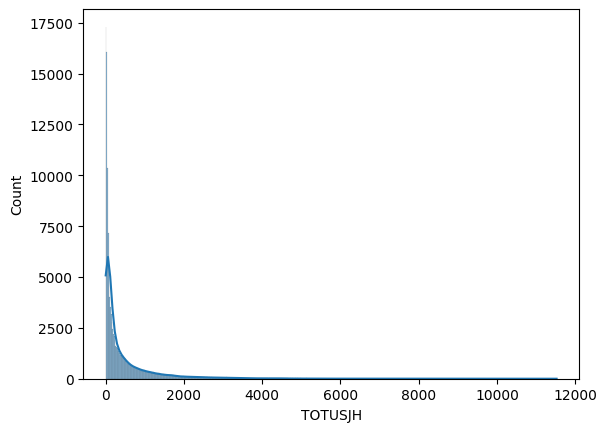



------------- Distribution for TOTBSQ -------------

Quantiles for TOTBSQ:
0.00    0.000000e+00
0.25    3.285640e+08
0.50    1.415764e+09
0.75    8.102095e+09
0.90    2.224901e+10
0.95    3.564405e+10
0.99    8.904889e+10
1.00    1.431918e+11
Name: TOTBSQ, dtype: float64


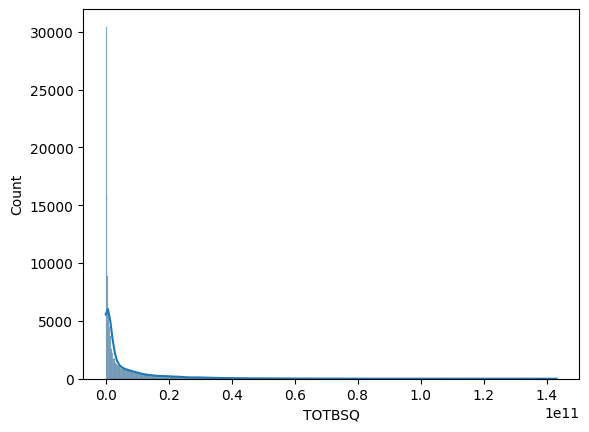



------------- Distribution for TOTPOT -------------

Quantiles for TOTPOT:
0.00    0.000000e+00
0.25    2.345178e+21
0.50    1.034712e+22
0.75    1.000415e+23
0.90    3.502577e+23
0.95    5.651564e+23
0.99    1.623278e+24
1.00    8.684370e+26
Name: TOTPOT, dtype: float64


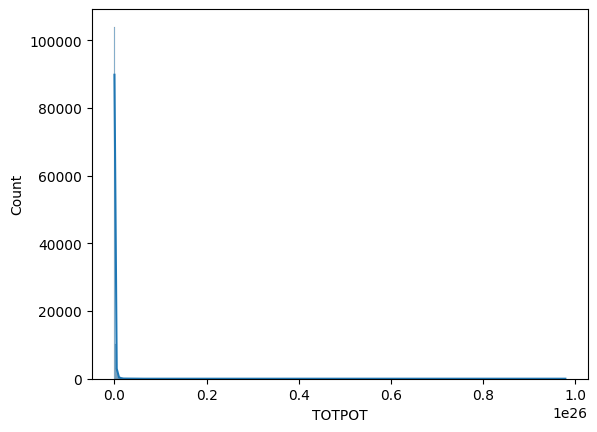



------------- Distribution for TOTUSJZ -------------

Quantiles for TOTUSJZ:
0.00    0.000000e+00
0.25    9.657009e+11
0.50    3.316949e+12
0.75    1.320731e+13
0.90    3.202258e+13
0.95    5.324299e+13
0.99    9.436829e+13
1.00    2.238240e+14
Name: TOTUSJZ, dtype: float64


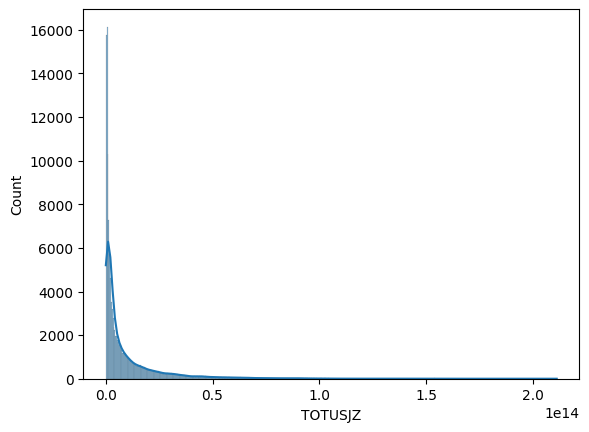



------------- Distribution for ABSNJZH -------------

Quantiles for ABSNJZH:
0.00       0.000000
0.25       3.129039
0.50      10.482238
0.75      46.700883
0.90     156.988520
0.95     296.662104
0.99     933.621629
1.00    2980.217588
Name: ABSNJZH, dtype: float64


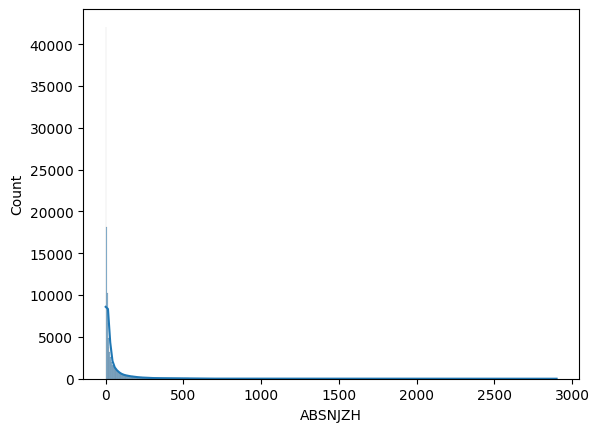



------------- Distribution for SAVNCPP -------------

Quantiles for SAVNCPP:
0.00    0.000000e+00
0.25    2.769544e+11
0.50    8.117772e+11
0.75    2.727791e+12
0.90    6.903282e+12
0.95    1.230638e+13
0.99    3.260649e+13
1.00    1.085462e+14
Name: SAVNCPP, dtype: float64


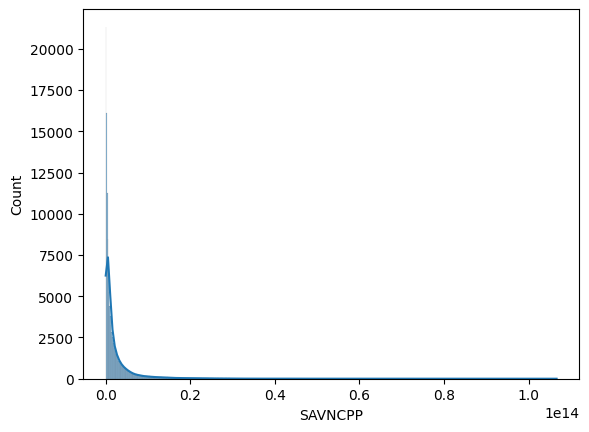



------------- Distribution for USFLUX -------------

Quantiles for USFLUX:
0.00    0.000000e+00
0.25    6.383398e+20
0.50    2.387424e+21
0.75    9.766953e+21
0.90    2.276904e+22
0.95    3.786746e+22
0.99    7.332506e+22
1.00    1.298067e+23
Name: USFLUX, dtype: float64


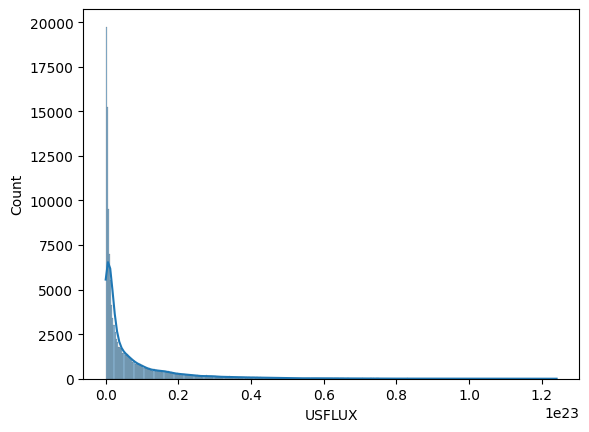



------------- Distribution for TOTFZ -------------

Quantiles for TOTFZ:
0.00   -5.264704e+25
0.25   -2.629256e+24
0.50   -7.696261e+23
0.75   -1.908992e+23
0.90   -6.781636e+22
0.95   -3.921326e+22
0.99    0.000000e+00
1.00    3.770667e+24
Name: TOTFZ, dtype: float64


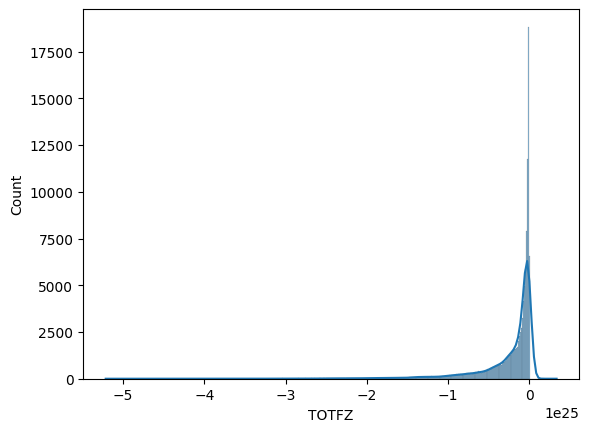



------------- Distribution for MEANPOT -------------

Quantiles for MEANPOT:
0.00    0.000000e+00
0.25    1.570245e+03
0.50    1.951349e+03
0.75    5.075132e+03
0.90    9.340626e+03
0.95    1.188043e+04
0.99    1.919212e+04
1.00    7.528810e+08
Name: MEANPOT, dtype: float64


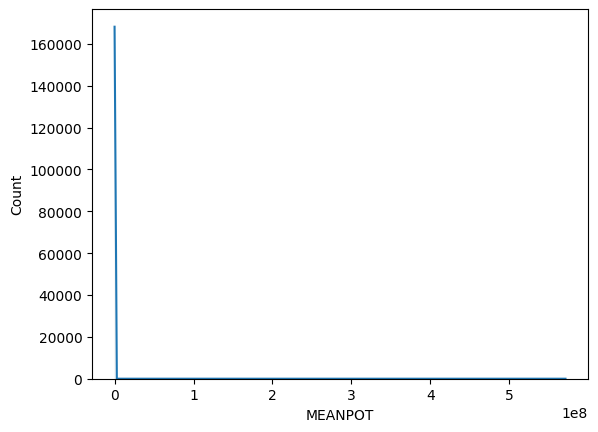



------------- Distribution for EPSZ -------------

Quantiles for EPSZ:
0.00   -0.990590
0.25   -0.629341
0.50   -0.566615
0.75   -0.373082
0.90   -0.201067
0.95   -0.137285
0.99    0.000000
1.00    0.999210
Name: EPSZ, dtype: float64


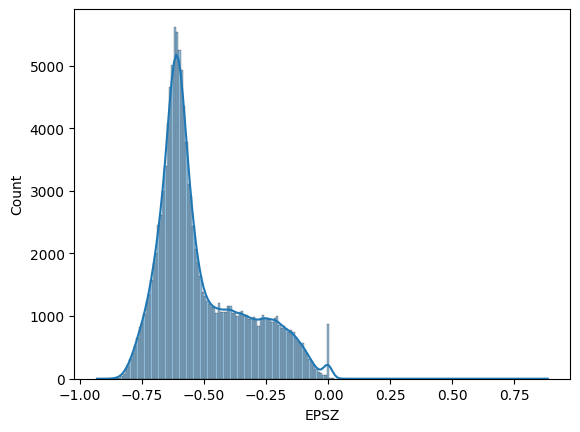



------------- Distribution for SHRGT45 -------------

Quantiles for SHRGT45:
0.00      0.000000
0.25      2.238806
0.50      4.806450
0.75     21.588660
0.90     37.829867
0.95     45.869472
0.99     62.523978
1.00    100.000000
Name: SHRGT45, dtype: float64


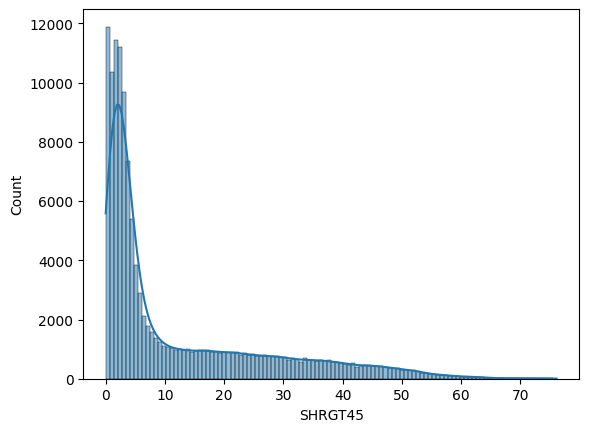



------------- Distribution for MEANSHR -------------

Quantiles for MEANSHR:
0.00      0.000000
0.25     21.925614
0.50     23.908588
0.75     32.098248
0.90     40.557786
0.95     44.648812
0.99     52.489316
1.00    135.784277
Name: MEANSHR, dtype: float64


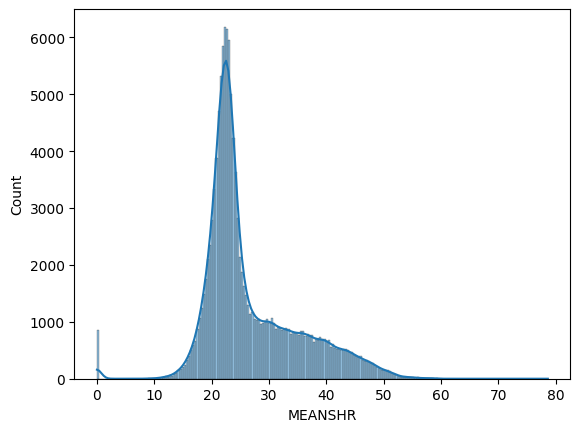



------------- Distribution for MEANGAM -------------

Quantiles for MEANGAM:
0.00     0.000000
0.25    28.116517
0.50    30.892600
0.75    40.147666
0.90    49.403653
0.95    53.874775
0.99    60.726475
1.00    88.861048
Name: MEANGAM, dtype: float64


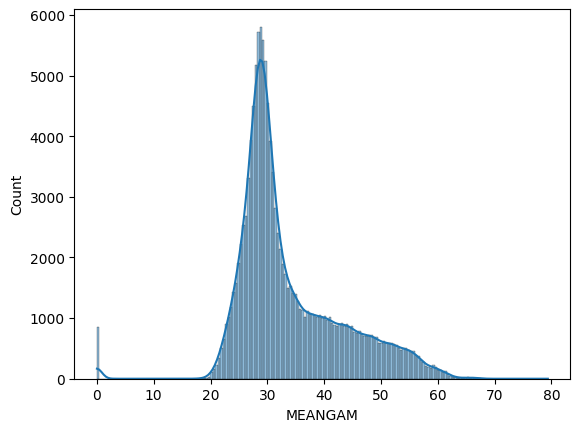



------------- Distribution for MEANGBT -------------

Quantiles for MEANGBT:
0.00      0.000000
0.25    103.112331
0.50    120.369263
0.75    134.126096
0.90    145.616928
0.95    153.799445
0.99    173.251768
1.00    310.705839
Name: MEANGBT, dtype: float64


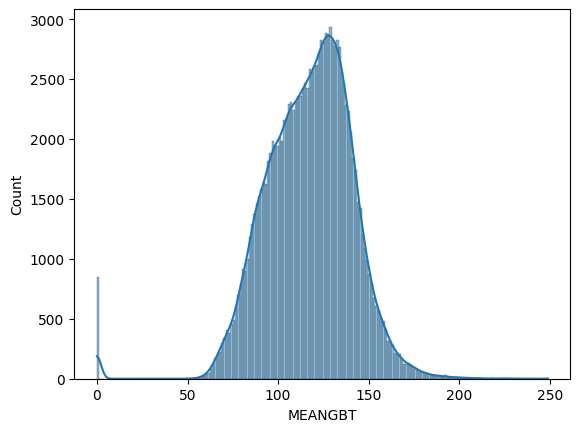



------------- Distribution for MEANGBZ -------------

Quantiles for MEANGBZ:
0.00      0.000000
0.25    104.246697
0.50    120.331833
0.75    134.379824
0.90    146.978980
0.95    156.208776
0.99    177.668603
1.00    282.302914
Name: MEANGBZ, dtype: float64


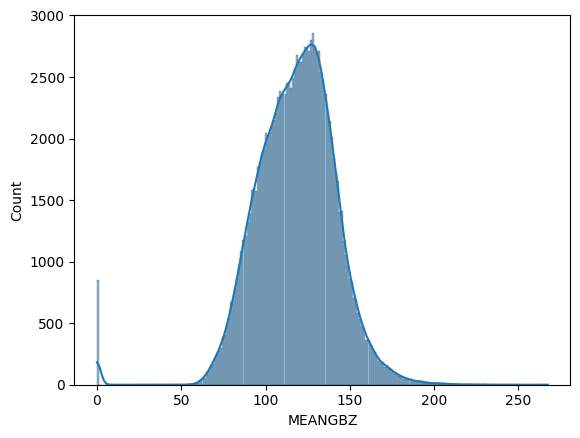



------------- Distribution for MEANGBH -------------

Quantiles for MEANGBH:
0.00      0.000000
0.25     43.060869
0.50     52.350020
0.75     61.567159
0.90     70.182915
0.95     76.876032
0.99     90.721497
1.00    192.120033
Name: MEANGBH, dtype: float64


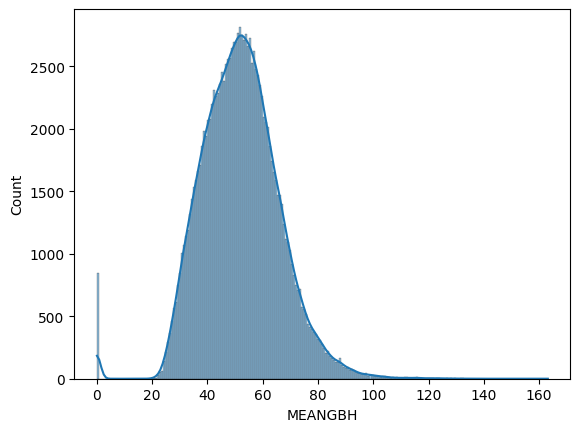



------------- Distribution for MEANJZH -------------

Quantiles for MEANJZH:
0.00   -0.245738
0.25   -0.002735
0.50    0.000814
0.75    0.004293
0.90    0.008199
0.95    0.011374
0.99    0.019729
1.00    0.478231
Name: MEANJZH, dtype: float64


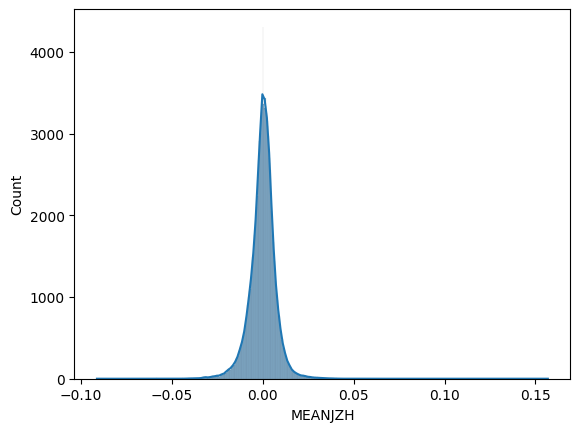



------------- Distribution for TOTFY -------------

Quantiles for TOTFY:
0.00   -1.198240e+25
0.25   -6.434142e+22
0.50    4.250516e+22
0.75    2.522364e+23
0.90    8.774203e+23
0.95    1.665199e+24
0.99    3.510965e+24
1.00    9.433046e+24
Name: TOTFY, dtype: float64


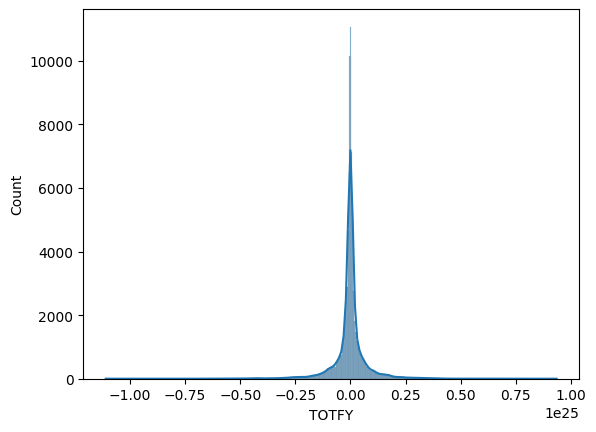



------------- Distribution for MEANJZD -------------

Quantiles for MEANJZD:
0.00   -52.278859
0.25    -0.077656
0.50     0.167768
0.75     0.552880
0.90     1.112381
0.95     1.545012
0.99     2.628465
1.00    56.066415
Name: MEANJZD, dtype: float64


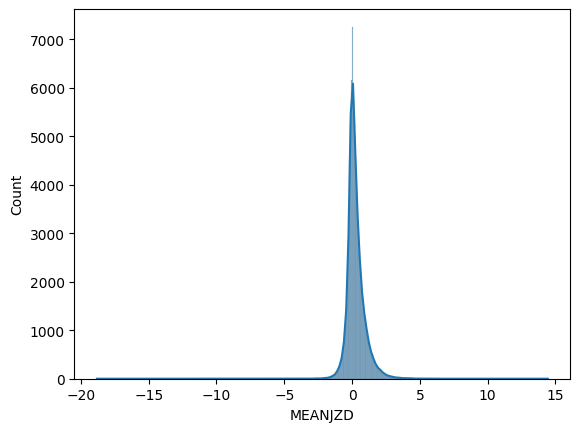



------------- Distribution for MEANALP -------------

Quantiles for MEANALP:
0.00   -50.795084
0.25    -0.008849
0.50     0.002700
0.75     0.014670
0.90     0.027120
0.95     0.037057
0.99     0.065539
1.00    21.198991
Name: MEANALP, dtype: float64


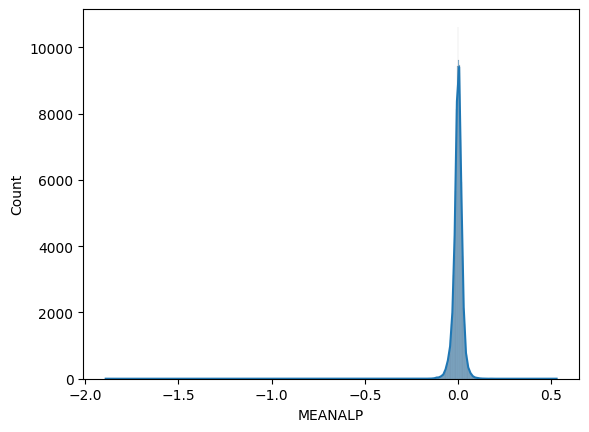



------------- Distribution for TOTFX -------------

Quantiles for TOTFX:
0.00   -1.721026e+25
0.25   -2.251631e+23
0.50    3.659977e+21
0.75    2.953154e+23
0.90    1.463685e+24
0.95    2.789334e+24
0.99    7.156380e+24
1.00    1.730162e+25
Name: TOTFX, dtype: float64


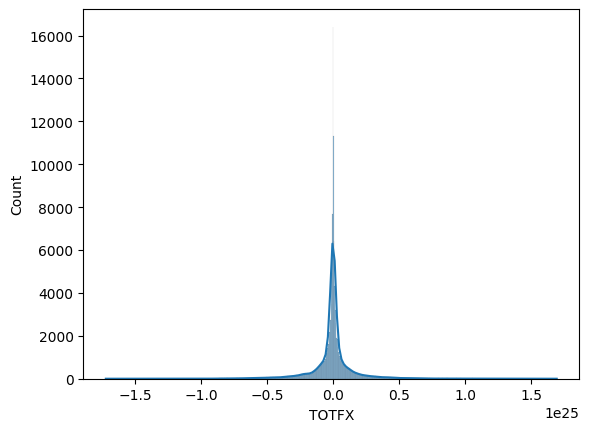



------------- Distribution for EPSY -------------

Quantiles for EPSY:
0.00   -0.493226
0.25   -0.048152
0.50    0.024628
0.75    0.124401
0.90    0.236974
0.95    0.275430
0.99    0.314441
1.00    0.491862
Name: EPSY, dtype: float64


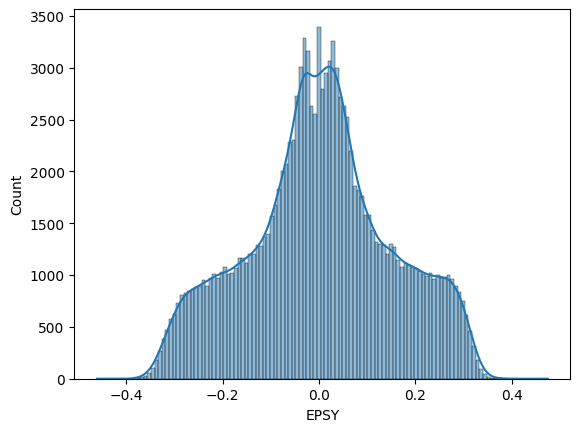



------------- Distribution for EPSX -------------

Quantiles for EPSX:
0.00   -0.494683
0.25   -0.151143
0.50    0.013773
0.75    0.165922
0.90    0.250733
0.95    0.278324
0.99    0.311363
1.00    0.465894
Name: EPSX, dtype: float64


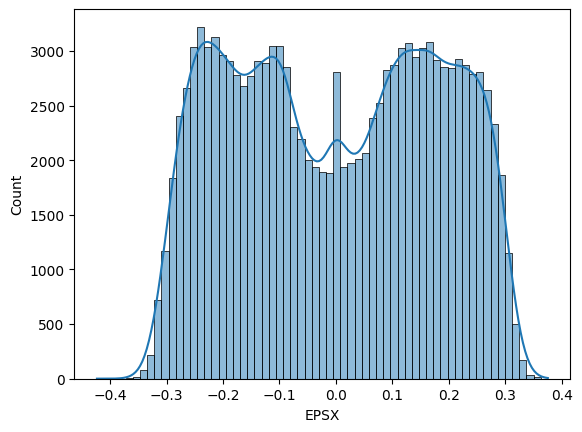



------------- Distribution for R_VALUE -------------

Quantiles for R_VALUE:
0.00    0.000000
0.25    0.000000
0.50    0.000000
0.75    3.680719
0.90    4.424079
0.95    4.728611
0.99    5.243847
1.00    5.838592
Name: R_VALUE, dtype: float64


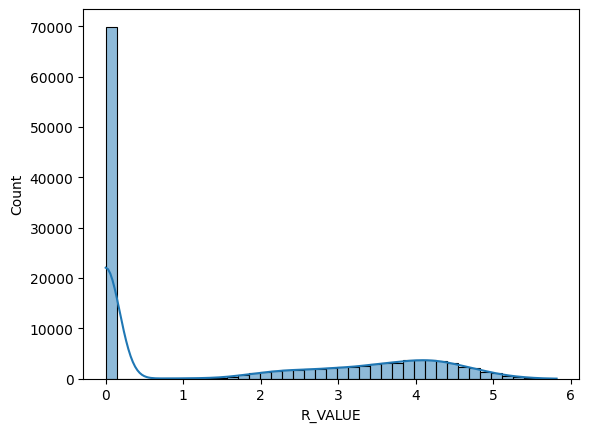



------------- Distribution for RBZ_VALUE -------------

Quantiles for RBZ_VALUE:
0.00    0.000000
0.25    0.000000
0.50    1.939726
0.75    3.595547
0.90    4.336398
0.95    4.610084
0.99    5.137281
1.00    5.707257
Name: RBZ_VALUE, dtype: float64


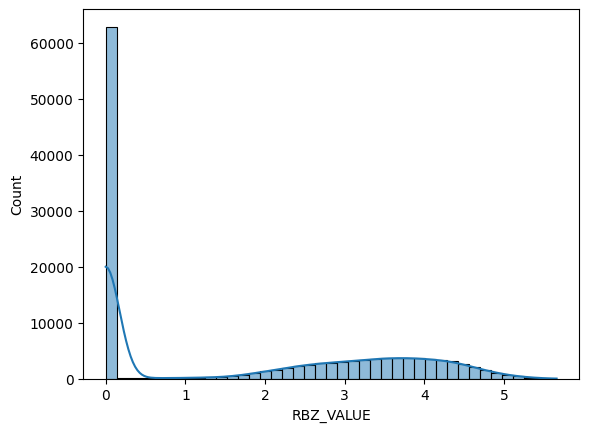



------------- Distribution for RBT_VALUE -------------

Quantiles for RBT_VALUE:
0.00    0.000000
0.25    0.000000
0.50    2.787695
0.75    4.059630
0.90    4.563035
0.95    4.772768
0.99    5.161545
1.00    5.529852
Name: RBT_VALUE, dtype: float64


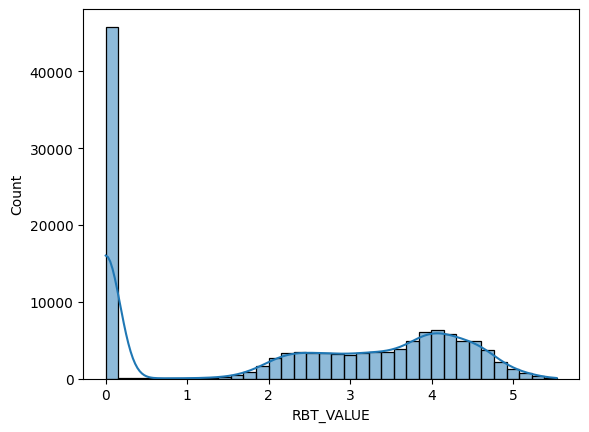



------------- Distribution for RBP_VALUE -------------

Quantiles for RBP_VALUE:
0.00    0.000000
0.25    0.000000
0.50    2.517145
0.75    3.911988
0.90    4.433281
0.95    4.664454
0.99    5.038286
1.00    5.468092
Name: RBP_VALUE, dtype: float64


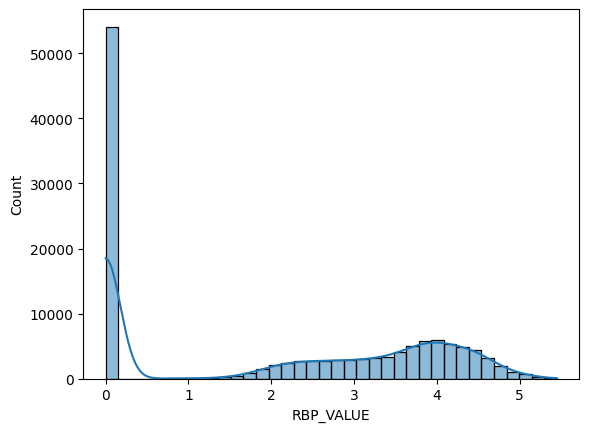



------------- Distribution for FDIM -------------

Quantiles for FDIM:
0.00    0.000000
0.25    0.000000
0.50    0.000000
0.75    0.000000
0.90    0.000000
0.95    0.000000
0.99    0.000000
1.00    0.002033
Name: FDIM, dtype: float64


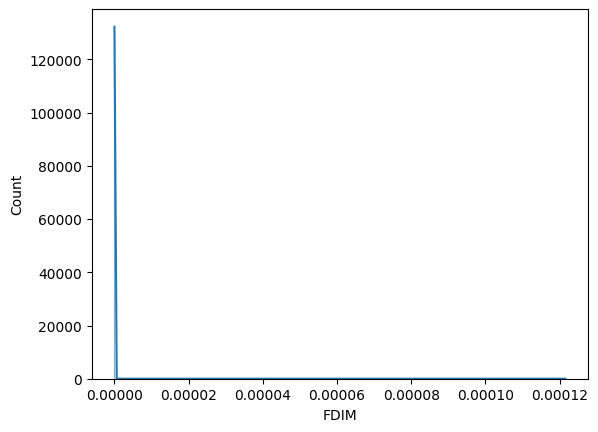



------------- Distribution for BZ_FDIM -------------

Quantiles for BZ_FDIM:
0.00    0.005981
0.25    0.000000
0.50    0.000000
0.75    0.000000
0.90    0.000000
0.95    0.000000
0.99    0.000205
1.00    0.005981
Name: BZ_FDIM, dtype: float64


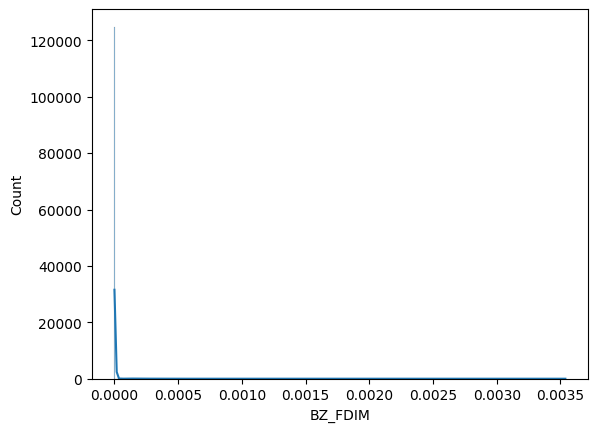



------------- Distribution for BT_FDIM -------------

Quantiles for BT_FDIM:
0.00    0.017201
0.25    0.000000
0.50    0.000000
0.75    0.000000
0.90    0.000101
0.95    0.000242
0.99    0.001548
1.00    0.017201
Name: BT_FDIM, dtype: float64


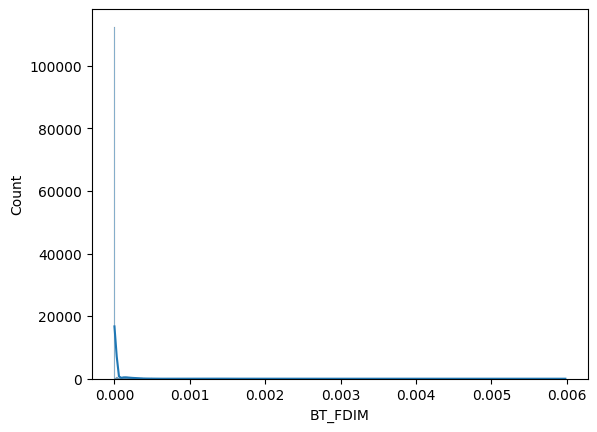



------------- Distribution for BP_FDIM -------------

Quantiles for BP_FDIM:
0.00    0.000000
0.25    0.000000
0.50    0.000000
0.75    0.000000
0.90    0.000000
0.95    0.000146
0.99    0.001421
1.00    0.017201
Name: BP_FDIM, dtype: float64


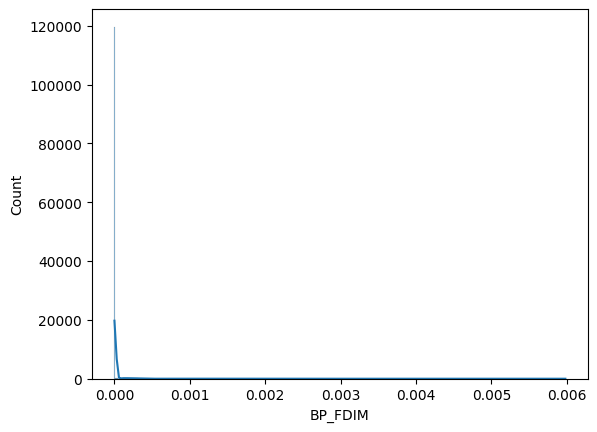



------------- Distribution for PIL_LEN -------------

Quantiles for PIL_LEN:
0.00        0.00
0.25        0.00
0.50        5.00
0.75      103.00
0.90      640.00
0.95     1441.05
0.99     4912.02
1.00    26094.00
Name: PIL_LEN, dtype: float64


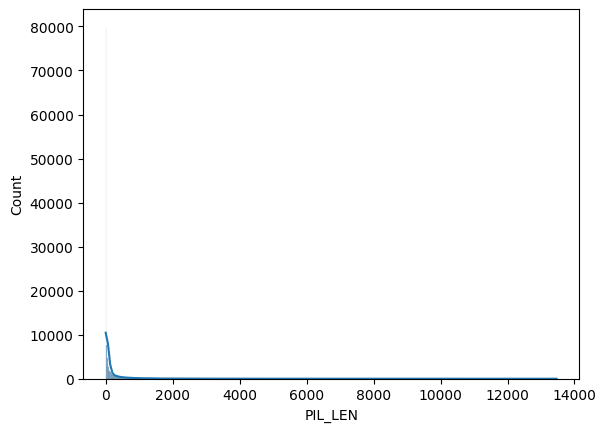



------------- Distribution for XR_MAX -------------

Quantiles for XR_MAX:
0.00   -9.999900e+04
0.25    3.973000e-07
0.50    7.091100e-07
0.75    1.156200e-06
0.90    1.963220e-06
0.95    3.083820e-06
0.99    1.039800e-05
1.00    6.997100e-04
Name: XR_MAX, dtype: float64


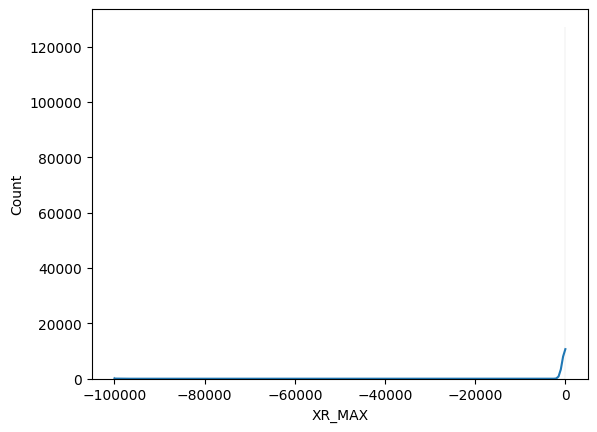

In [8]:
for feature in numeric_ddf.columns:
    print(f"\n\n------------- Distribution for {feature} -------------\n")
    print(f"Quantiles for {feature}:\n{quantiles[feature]}")
    sns.histplot(data=sample_df, x=feature, kde=True)
    save_path = os.path.join(save_dir1, f"{feature}_distribution.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

## Heavily Right-Skewed Features
- Features: TOTUSJH, TOTBSQ, TOTPOT, TOTUSJZ, ABSNJZH, SAVNCPP, USFLUX, PIL_LEN, MEANPOT.
- The median (50%) is tiny compared to the maximum (100%). Most of the data is clustered near zero, with a long tail of extremely large values. These large values are probably the most interesting ones (related to large flares).
- Such highly right skewed features are the top candidates for **Logathmic Transformation", as it compresses the large values and spreads out the smaller ones,  making the distribution more symmetrical and a symmetrical distribution is often easier for models to learn from.

## Zero Inflated Features
- Features: FDIM, BZ_FDIM, BT_FDIM, BP_FDIM, and R_VALUE.
- The 75th percentile (and sometimes even the 99th!) is zero. This means the vast majority of observations for these features are zero.
- These features might have low predictive power, but the rare non-zero values could be significant. For now, we will keep them. They do not need a log transform, but they will need scaling.

## Left-Skewed or Symmetric around Zero
- Features: TOTFZ, TOTFY, TOTFX, MEANJZH, MEANJZD.
- These distributions have significant negative values. TOTFZ is a great example of a left skew, where the 99th percentile is 0, but the minimum is a large negative number.
- But note that we should not apply log transformation to these, as log is not defined for -ve values. These are best handled by scaling.

# Class Imbalence

Class Distribution:
 label
C     1261440
Q    10554840
B      712560
X       23100
M      231780
Name: count, dtype: int64[pyarrow]


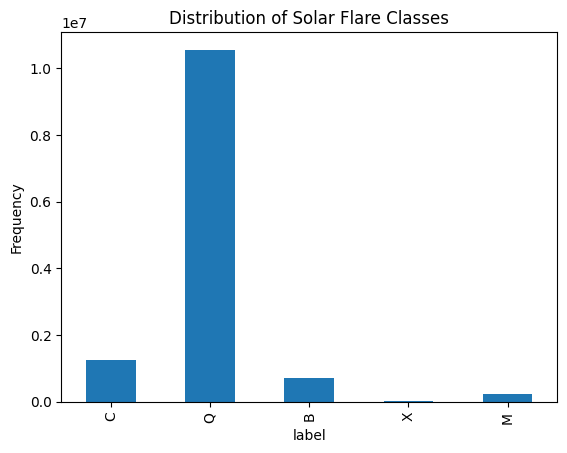

In [9]:
class_dist = ddf["label"].value_counts().compute()
print("Class Distribution:\n", class_dist)

class_dist.plot(kind = "bar")
plt.title("Distribution of Solar Flare Classes")
plt.ylabel("Frequency")
save_path = os.path.join(save_dir1, "class_distribution.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Correlational Analysis

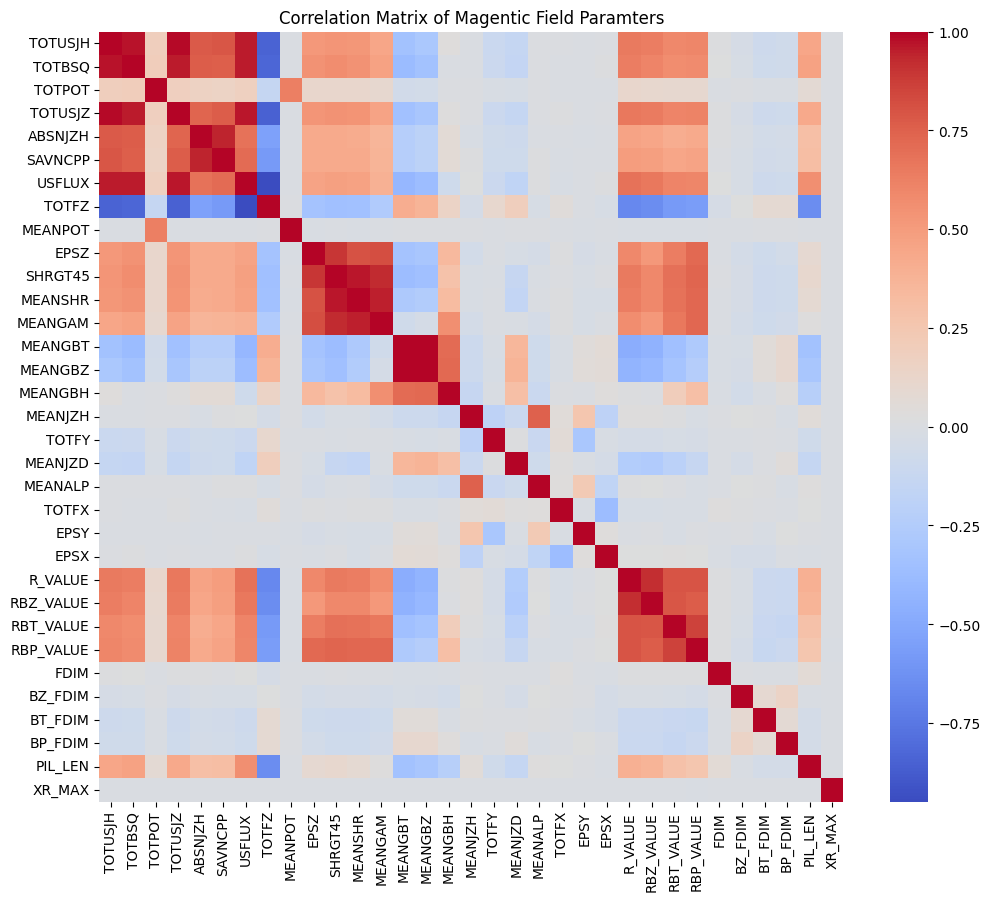

In [10]:
correlation_matrix = numeric_ddf.corr().compute()
plt.figure(figsize = (12,10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix of Magentic Field Paramters")
save_path = os.path.join(save_dir1, "correlation_matrix.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

## Postively Correlated Features
Looking at the top-left corner of the matrix. There is a large, dark red square spanning from TOTUSJH to USFLUX, which tells us that they are extremely highly correlated with each other. As are all different ways of measuring the overall size and energy of the active region. When one is high, the others are almost always high too. Hence, including all of these features in a model is redundant. It's like telling the model the same thing in six different ways. This can make the model harder to interpret and can destabilize some algorithms.

There's another distinct red block of correlations around MEANSHR, MEANGAM, MEANGBT, MEANGBZ, and MEANGBH. These variables, which likely represent the average shear, gradient, and magnetic field components, are also highly correlated among themselves.They collectively describe the magnetic field's complexity and stress level. Hence, similar to the first cluster, we don't likely need all of these.

And lastly the features R_VALUE, RBZ_VALUE, RBT_VALUE, and RBP_VALUE show a strong positive correlation with each other. This is expected as they are related calculations.

## Negatively Correlated Features
Notice the blue squares around "Energy/Flux" cluster. For example, TOTFZ has a negative correlation with the "Energy/Flux" cluster. This is physically meaningful and represents a relationship between the vertical component of the magnetic field and the overall energy.